In [1]:
import numpy as np
import pickle
from astropy.io import fits
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
import gd1_util
import GMC_util
import os

ro=8.
vo=220.


Populating the interactive namespace from numpy and matplotlib


### Test whether very old impacts are important. To do this, we will impact a mock GD-1 stream by subhalos at ~7 Gyr and compute the density today.

In [2]:
ro=8.
vo=220.

def parse_times(times,age,ro,vo):
    if 'sampling' in times:
        nsam= int(times.split('sampling')[0])
        return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
                for ti in numpy.arange(1,nsam+1)/(nsam+1.)*age]
    return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
            for ti in times.split(',')]
            
timpacts= parse_times('0.5,1.,2.,3.,4.,5.,6.,7.,7.5,8.,8.5',9.,ro=ro,vo=vo)

print (np.array(timpacts)*bovy_conversion.time_in_Gyr(vo,ro))

[0.5 1.  2.  3.  4.  5.  6.  7.  7.5 8.  8.5]


In [3]:
sdf_smooth= gd1_util.setup_gd1model()


In [74]:
#randomly pick N stream chunk indices

N=5
import random

ind=random.sample(range(1,80),N)
    
print (ind)

[46, 52, 65, 25, 39]


In [77]:
pepperfilename='GD1_oldimpactstest_MW2014_leadingarm.pkl'
if os.path.exists(pepperfilename):
    with open(pepperfilename,'rb') as savefile:
        sdf_pepper= pickle.load(savefile,encoding='latin1')
else:
    
    sdf_pepper= gd1_util.setup_gd1model(timpact=timpacts)
    save_pickles(pepperfilename,sdf_pepper)

print (sdf_pepper._timpact*bovy_conversion.time_in_Gyr(vo,ro))

apar_full,x_full,y_full,z_full,vx_full,vy_full,vz_full = GMC_util.aparxv_stream(sdf_smooth,sdf_pepper)

tim_ind=1 # 1 Gyr ago



vsub=np.empty((len(ind),3))
apar_imp=[]

for ii in range(len(ind)):
    vx=vx_full[tim_ind][ind[ii]] + 0.1*random.random()*random.randint(-5, 5)
    vy=vy_full[tim_ind][ind[ii]] + 0.1*random.random()*random.randint(-5, 5)
    vz=vz_full[tim_ind][ind[ii]] + 0.1*random.random()*random.randint(-5, 5)
    vsub[ii]=np.c_[vx,vy,vz]
    apar_imp.append(apar_full[tim_ind][ind[ii]])

print (vsub)


M_imp=list(np.ones(len(ind))*(10**7.)/bovy_conversion.mass_in_msol(vo,ro))

def rs(M):
    return 1.05*(M/10**8.)**(0.5)

rs_imp=[rs(m)/8. for m in M_imp]

timp=sdf_pepper._timpact[tim_ind]

impactb=list(0.7*np.ones(len(ind))/8.)

#impactb=np.array(rs_imp)*5.

print (apar_imp,impactb,rs_imp,M_imp)

[0.5 1.  2.  3.  4.  5.  6.  7.  7.5 8.  8.5]
[[0.50774734 0.76059817 0.77518257]
 [0.51746092 1.122752   0.71071795]
 [0.30194483 0.63354015 0.71739849]
 [0.54523666 0.85936937 0.68260914]
 [0.44831973 1.11306152 0.72114799]]
[0.22875653755128114, 0.2585943467971004, 0.3232429334963755, 0.12432420519091365, 0.1939457600978253] [0.0875, 0.0875, 0.0875, 0.0875, 0.0875] [1.383286638995959e-07, 1.383286638995959e-07, 1.383286638995959e-07, 1.383286638995959e-07, 1.383286638995959e-07] [0.00011107740883445186, 0.00011107740883445186, 0.00011107740883445186, 0.00011107740883445186, 0.00011107740883445186]


[1.03870996 1.0853565  1.17340081 1.31577918 1.51357407 1.75083539
 1.99930573 2.2322932  2.43844336 2.62370912 2.79605541 2.940311
 3.00411544 2.91632809 2.6348649  2.18771143 1.66825243 1.18577246
 0.81223065 0.56322597 0.42843743 0.34452249 0.29631581 0.2661822
 0.24522222 0.22936492 0.21674183 0.20639673 0.19776133 0.19046851
 0.18427398 0.17899498 0.17447361 0.17058531 0.16725704 0.16444762
 0.16210698 0.1601687  0.15858217 0.15733553 0.15643743 0.15588216
 0.15564076 0.1556856  0.15601797 0.15666693 0.15765995 0.15899985
 0.16067813 0.16271056 0.16514871 0.16805155 0.1714591  0.17540864
 0.17997051 0.18525344 0.19138274 0.19849837 0.20678481 0.21650146
 0.22800698 0.2418175  0.25874335 0.28013155 0.30822091 0.34655576
 0.40032701 0.47650854 0.58367289 0.75095797 0.94569037 1.18883071
 1.46804162 1.75492392 2.01012608 2.19692159 2.2963168  2.31408214
 2.27553056 2.21262285 2.15215812 2.11087455 2.09737382 2.11684235
 2.17375757 2.2687505  2.38849292 2.4937589  2.54882669 2.4235612

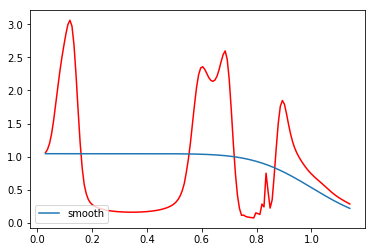

In [78]:
#import streampepperdf

sdf_pepper.set_impacts(impactb=impactb,subhalovel=vsub,impact_angle=apar_imp,timpact=[timp],rs=rs_imp,GM=M_imp)

apar=np.linspace(0.03,1.14,150)

dens_unp=[]
dens=[]
omega_unp=[]
omega=[]

for a in apar :
    dens_unp.append(sdf_smooth._density_par(a))
    omega_unp.append(sdf_smooth.meanOmega(a,oned=True))
    dens.append(sdf_pepper._densityAndOmega_par_approx(a)[0])
    omega.append(sdf_pepper._densityAndOmega_par_approx(a)[1])
    
#sdf_pepper._dens_unp/numpy.sum(sdf_pepper._dens_unp)/(xs[1]-xs[0])
dens_unp=np.array(dens_unp)
dens=np.array(dens)
omega=np.array(omega)

print (dens)

plt.figure()
plt.plot(apar,dens/np.sum(dens)/(apar[1]-apar[0]),c='r')
plt.plot(apar,dens_unp/np.sum(dens_unp)/(apar[1]-apar[0]),label='smooth')
plt.legend(loc='lower left')

plt.show()


In [79]:
pepperfilename='GD1_oldimpactstest_MW2014_leadingarm.pkl'
if os.path.exists(pepperfilename):
    with open(pepperfilename,'rb') as savefile:
        sdf_pepper= pickle.load(savefile,encoding='latin1')
else:
    
    sdf_pepper= gd1_util.setup_gd1model(timpact=timpacts)
    save_pickles(pepperfilename,sdf_pepper)

print (sdf_pepper._timpact*bovy_conversion.time_in_Gyr(vo,ro))

apar_full,x_full,y_full,z_full,vx_full,vy_full,vz_full = GMC_util.aparxv_stream(sdf_smooth,sdf_pepper)

tim_ind=9 # 8 Gyr ago



vsub=np.empty((len(ind),3))
apar_imp=[]

for ii in range(len(ind)):
    vx=vx_full[tim_ind][ind[ii]] + 0.1*random.random()*random.randint(-5, 5)
    vy=vy_full[tim_ind][ind[ii]] + 0.1*random.random()*random.randint(-5, 5)
    vz=vz_full[tim_ind][ind[ii]] + 0.1*random.random()*random.randint(-5, 5)
    vsub[ii]=np.c_[vx,vy,vz]
    apar_imp.append(apar_full[tim_ind][ind[ii]])

print (vsub)


M_imp=list(np.ones(len(ind))*(10**7.)/bovy_conversion.mass_in_msol(vo,ro))

def rs(M):
    return 1.05*(M/10**8.)**(0.5)

rs_imp=[rs(m)/8. for m in M_imp]

timp=sdf_pepper._timpact[tim_ind]

impactb=list(0.7*np.ones(len(ind))/8.)

#impactb=np.array(rs_imp)*5.

print (apar_imp,impactb,rs_imp,M_imp)

[0.5 1.  2.  3.  4.  5.  6.  7.  7.5 8.  8.5]
[[ 0.84146891 -0.52394283  0.10900311]
 [ 0.5766097  -0.56008195  0.64686777]
 [ 0.98566732 -0.48275685  0.30979803]
 [ 0.6620215  -0.50478827  0.23505676]
 [ 0.65921385 -0.28339158  0.53604686]]
[0.071846853705707, 0.08121818244992965, 0.10152272806241207, 0.03904720310092772, 0.06091363683744724] [0.0875, 0.0875, 0.0875, 0.0875, 0.0875] [1.383286638995959e-07, 1.383286638995959e-07, 1.383286638995959e-07, 1.383286638995959e-07, 1.383286638995959e-07] [0.00011107740883445186, 0.00011107740883445186, 0.00011107740883445186, 0.00011107740883445186, 0.00011107740883445186]


[1.03951026 1.04217352 1.04491633 1.04773198 1.05061226 1.05354888
 1.05653257 1.05955332 1.06260074 1.06566307 1.06872889 1.07178612
 1.07482235 1.07782498 1.08078154 1.08367878 1.08650447 1.08924632
 1.09189238 1.09443152 1.09685208 1.09914428 1.10129868 1.10330672
 1.10516122 1.10685453 1.10838161 1.10973798 1.11092031 1.11192636
 1.11275554 1.1134068  1.11388188 1.11418301 1.11431343 1.11427731
 1.1140805  1.11372703 1.1132245  1.11258011 1.11180161 1.11089712
 1.10987499 1.10874423 1.10751341 1.1061913  1.10478653 1.10330883
 1.10176338 1.10015942 1.09850414 1.09680411 1.09506526 1.09329353
 1.0914915  1.08966359 1.08781232 1.08593921 1.08404476 1.08212915
 1.08018887 1.07822198 1.07622442 1.07419091 1.07211494 1.06998876
 1.06780395 1.06554886 1.06321275 1.06078288 1.05824528 1.05558478
 1.05278558 1.04982897 1.04669713 1.04337052 1.03982868 1.03605034
 1.03201384 1.02769562 1.02307305 1.01812261 1.01282062 1.00714337
 1.00106742 0.99456932 0.98762658 0.98021734 0.97232077 0.9639

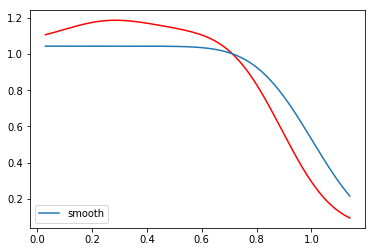

In [80]:
#import streampepperdf

sdf_pepper.set_impacts(impactb=impactb,subhalovel=vsub,impact_angle=apar_imp,timpact=[timp],rs=rs_imp,GM=M_imp)

apar=np.linspace(0.03,1.14,150)

dens_unp=[]
dens=[]
omega_unp=[]
omega=[]

for a in apar :
    dens_unp.append(sdf_smooth._density_par(a))
    omega_unp.append(sdf_smooth.meanOmega(a,oned=True))
    dens.append(sdf_pepper._densityAndOmega_par_approx(a)[0])
    omega.append(sdf_pepper._densityAndOmega_par_approx(a)[1])
    
#sdf_pepper._dens_unp/numpy.sum(sdf_pepper._dens_unp)/(xs[1]-xs[0])
dens_unp=np.array(dens_unp)
dens=np.array(dens)
omega=np.array(omega)

print (dens)

plt.figure()
plt.plot(apar,dens/np.sum(dens)/(apar[1]-apar[0]),c='r')
plt.plot(apar,dens_unp/np.sum(dens_unp)/(apar[1]-apar[0]),label='smooth')
plt.legend(loc='lower left')

plt.show()


In [28]:
from gd1_util_MWhaloshape import lb_to_phi12

def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3,poly_norm=True):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    #outll= numpy.linspace(numpy.amin(mT[0]),numpy.amax(mT[0]),len(apars))
    phi12=lb_to_phi12(mT[0],mT[1],degree=True)
    phi1 = phi12[:,0]
    
    print (phi1)
    phi1[phi1 > 180.] -=360.
    phi1 = phi1[::-1]
    print (phi1)
    ipphi1= interpolate.InterpolatedUnivariateSpline(phi1,apars)
    
    #pp= Polynomial.fit(apars,dens,deg=3)
    outphi1= numpy.linspace(-60.,-5.,300)
    # Interpolate density
    #ppa=np.array([pp(a) for a in apars])
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outphi1,ipdens(ipphi1(outphi1)))

phi1,denss=convert_dens_to_obs(apar,dens,dens_unp,omega)

#print (phi1,denss)
    

[357.88130513 357.29679824 356.70656601 356.1105668  355.50876962
 354.90113958 354.28764656 353.66826385 353.04296737 352.4117336
 351.7745479  351.13139009 350.48225601 349.82713003 349.16601618
 348.49890923 347.82581766 347.14674903 346.46171781 345.7707433
 345.07384866 344.37106444 343.66242361 342.94796771 342.22774225
 341.50179947 340.77019633 340.03299807 339.29027434 338.54210378
 337.78856558 337.02975494 336.26576386 335.4967009  334.72266995
 333.94379504 333.16019337 332.3720018  331.57935311 330.78239465
 329.98127618 329.17615401 328.36719566 327.55456644 326.73844714
 325.91901722 325.09646418 324.27098353 323.44277174 322.61203261
 321.77897631 320.94381072 320.10675657 319.2680305  318.42785692
 317.5864606  316.7440712  315.90091531 315.05723    314.21324116
 313.36918917 312.52530029 311.68181506 310.83895847 309.99697012
 309.15607077 308.31649841 307.47846775 306.64221159 305.80794058
 304.97587889 304.14622964 303.31920944 302.49501192 301.67384526
 300.8558903

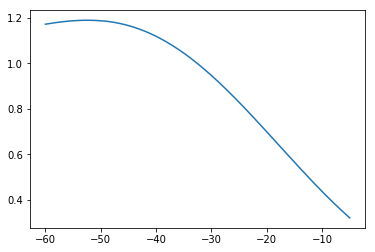

In [10]:
plt.figure()
plt.plot(phi1,denss)
plt.show()